In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import torch
import zipfile
import glob
import os
import shutil
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn

In [3]:
train_path = '/kaggle/working/train/train'

In [4]:
with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')

In [5]:
paths = glob.glob('/kaggle/working/train/train/*.jpg')


In [6]:
all_data = []
#category={'dog':1,'cat':0}

In [7]:
for path in paths:
    file_name = path.split('/')[-1]
    category=-1
    if 'dog' in file_name:
        data = {'file':path,'label':1}
    else:
        data = {'file':path,'label':0}
    all_data.append(data)

In [8]:
all_data[:10]

[{'file': '/kaggle/working/train/train/dog.5509.jpg', 'label': 1},
 {'file': '/kaggle/working/train/train/cat.7963.jpg', 'label': 0},
 {'file': '/kaggle/working/train/train/cat.225.jpg', 'label': 0},
 {'file': '/kaggle/working/train/train/dog.6735.jpg', 'label': 1},
 {'file': '/kaggle/working/train/train/cat.3181.jpg', 'label': 0},
 {'file': '/kaggle/working/train/train/cat.319.jpg', 'label': 0},
 {'file': '/kaggle/working/train/train/cat.3302.jpg', 'label': 0},
 {'file': '/kaggle/working/train/train/cat.12213.jpg', 'label': 0},
 {'file': '/kaggle/working/train/train/dog.6671.jpg', 'label': 1},
 {'file': '/kaggle/working/train/train/cat.5757.jpg', 'label': 0}]

In [9]:
len(all_data)

25000

In [10]:
train_df = pd.DataFrame(data=all_data) 

In [11]:
train_df.head()

,file,label
0,/kaggle/working/train/train/dog.5509.jpg,1
1,/kaggle/working/train/train/cat.7963.jpg,0
2,/kaggle/working/train/train/cat.225.jpg,0
3,/kaggle/working/train/train/dog.6735.jpg,1
4,/kaggle/working/train/train/cat.3181.jpg,0


In [12]:
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [13]:
len(val_df)

5000

In [14]:
class DogCatDataset(Dataset):
    def __init__(self,df,tfms=None):
        self.df = df
        if tfms is None:
            self.transforms= transforms.Compose([
                                         transforms.Resize((224,224)),
                                         transforms.RandomRotation(20),
                                         transforms.RandomVerticalFlip(p=0.1),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                         ])
        else:
            self.transfroms = tfms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label = self.df.iloc[idx][1]
        img = Image.open(self.df.iloc[idx][0])
        img = self.transforms(img)
        return img,label

In [15]:
train_ds = DogCatDataset(train_df)
val_ds = DogCatDataset(val_df)

In [16]:
train_dl = DataLoader(train_ds,batch_size=64,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=64,shuffle=True)

In [17]:
model = models.resnet34()
            

In [18]:
class DogCatModel(nn.Module):
    def __init__(self,model):
        super(DogCatModel,self).__init__()
        self.model = model
        self.model.fc = nn.Linear(self.model.fc.in_features,2)
    def forward(self,image):
        return self.model(image)

In [19]:
dcModel = DogCatModel(model)

In [20]:
device = torch.device('cuda')

In [21]:
dcModel.to(device)

DogCatModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [22]:
optimizer = optim.Adam(params=model.parameters())

In [23]:
lossfunc = nn.CrossEntropyLoss()

In [24]:
epochs = 10
total=0
for epoch in range(epochs):
    accuracy = 0
    correct = 0
    val_correct = 0
    val_accuracy =0
    for index, (x,y) in enumerate(train_dl):
        x,y =x.to(device),y.to(device)
        prediction = dcModel(x)
        optimizer.zero_grad()
        loss = lossfunc(prediction,y)
        _, predicted = torch.max(prediction.data, 1)
        correct += (predicted == y).float().sum()
        loss.backward()
        optimizer.step()
    accuracy = 100 * correct / len(train_ds)
    with torch.no_grad():
        for index, (x,y) in enumerate(val_dl):
            x,y =x.to(device),y.to(device)
            val_prediction = dcModel(x)
            _, val_predicted = torch.max(val_prediction.data, 1)
            val_correct += (val_predicted == y).float().sum()
        val_accuracy = 100 * val_correct / len(val_ds)
    print("Epoch {} Train Accuracy = {} Validation Accuracy = {}".format(epoch,accuracy,val_accuracy))

Epoch 0 Train Accuracy = 60.89999771118164 Validation Accuracy = 62.21999740600586
Epoch 1 Train Accuracy = 66.23500061035156 Validation Accuracy = 68.73999786376953
Epoch 2 Train Accuracy = 72.03499603271484 Validation Accuracy = 75.69999694824219
Epoch 3 Train Accuracy = 75.23999786376953 Validation Accuracy = 75.65999603271484
Epoch 4 Train Accuracy = 77.8499984741211 Validation Accuracy = 80.54000091552734
Epoch 5 Train Accuracy = 80.61499786376953 Validation Accuracy = 80.5999984741211
Epoch 6 Train Accuracy = 81.82999420166016 Validation Accuracy = 82.29999542236328
Epoch 7 Train Accuracy = 83.60499572753906 Validation Accuracy = 85.25999450683594
Epoch 8 Train Accuracy = 85.33499908447266 Validation Accuracy = 84.95999908447266
Epoch 9 Train Accuracy = 86.7449951171875 Validation Accuracy = 87.27999877929688


In [26]:
torch.save(dcModel.state_dict(),'/kaggle/working/model.pth')

In [27]:
with zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

In [ ]:
test_file_names = glob.glob('/kaggle/working/test/test1/*.jpg')
test_file_names

In [32]:
transforms= transforms.Compose([
                                         transforms.Resize((224,224)),
                                         transforms.RandomRotation(20),
                                         transforms.RandomVerticalFlip(p=0.1),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                         ])

In [36]:
result = []
dcModel.eval()
for file in test_file_names:
    img = Image.open(file)
    t_img = transforms(img)
    t_img = t_img[None,:]
    t_img = t_img.to(device)
    with torch.no_grad():
        prediction= dcModel(t_img)
        _,label = torch.max(prediction,dim=1);
        result.append({'file':file,'label':label})

In [37]:
result[:10]

[{'file': '/kaggle/working/test/test1/8839.jpg',
  'label': tensor([1], device='cuda:0')},
 {'file': '/kaggle/working/test/test1/2877.jpg',
  'label': tensor([1], device='cuda:0')},
 {'file': '/kaggle/working/test/test1/121.jpg',
  'label': tensor([1], device='cuda:0')},
 {'file': '/kaggle/working/test/test1/4989.jpg',
  'label': tensor([1], device='cuda:0')},
 {'file': '/kaggle/working/test/test1/8894.jpg',
  'label': tensor([0], device='cuda:0')},
 {'file': '/kaggle/working/test/test1/11950.jpg',
  'label': tensor([0], device='cuda:0')},
 {'file': '/kaggle/working/test/test1/998.jpg',
  'label': tensor([1], device='cuda:0')},
 {'file': '/kaggle/working/test/test1/8661.jpg',
  'label': tensor([1], device='cuda:0')},
 {'file': '/kaggle/working/test/test1/9432.jpg',
  'label': tensor([0], device='cuda:0')},
 {'file': '/kaggle/working/test/test1/1182.jpg',
  'label': tensor([1], device='cuda:0')}]

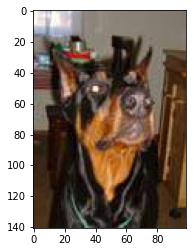

In [39]:
check_img = Image.open('/kaggle/working/test/test1/8839.jpg')
plt.imshow(check_img)

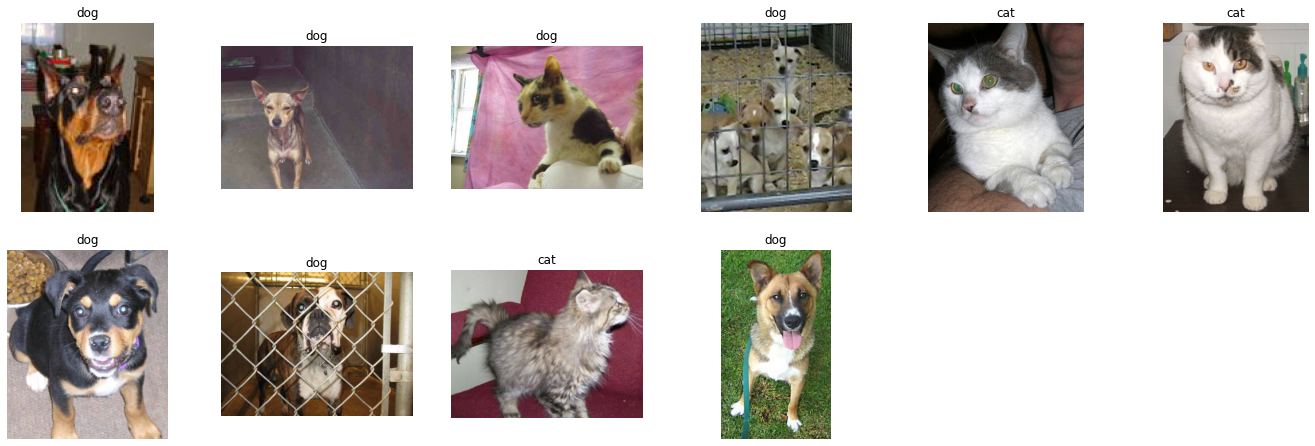

In [44]:
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(result[:10]):
    plt.subplot(4,6,num+1)
    plt.title(ad[sample['label'].item()])
    plt.axis('off')
    plt.imshow(Image.open(sample['file']))